## We can make difference maps to highlight differences between an MS subject and the atlas of tissue classification.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import nibabel as nib
import time
from scipy.stats import pearsonr, spearmanr

## Set up base folder right off the bat, this is where data lives
base_folder = "/Users/sharada/Documents/Projects/MDDE/V3/"

### Here we make difference maps of specific differences bewteen an MS subject and the atlas of tissue classifiction that we can quantify (rather than qualitatively looking at the MS subject's tissue classification and the atlas and looking for changes). 

### This requires that the atlas of tissue classification be warped to each subject, so that we can take direct differences. See processing/atlas_warp.sh and processing/example_processing_usage.sh to do this.

### We only look at differences in what the atlas thinks should be white matter (red, orange, yellow clusters) that get classified differently in MS. 

### Also note the correspondence between cluster numbers in the code and the paper:
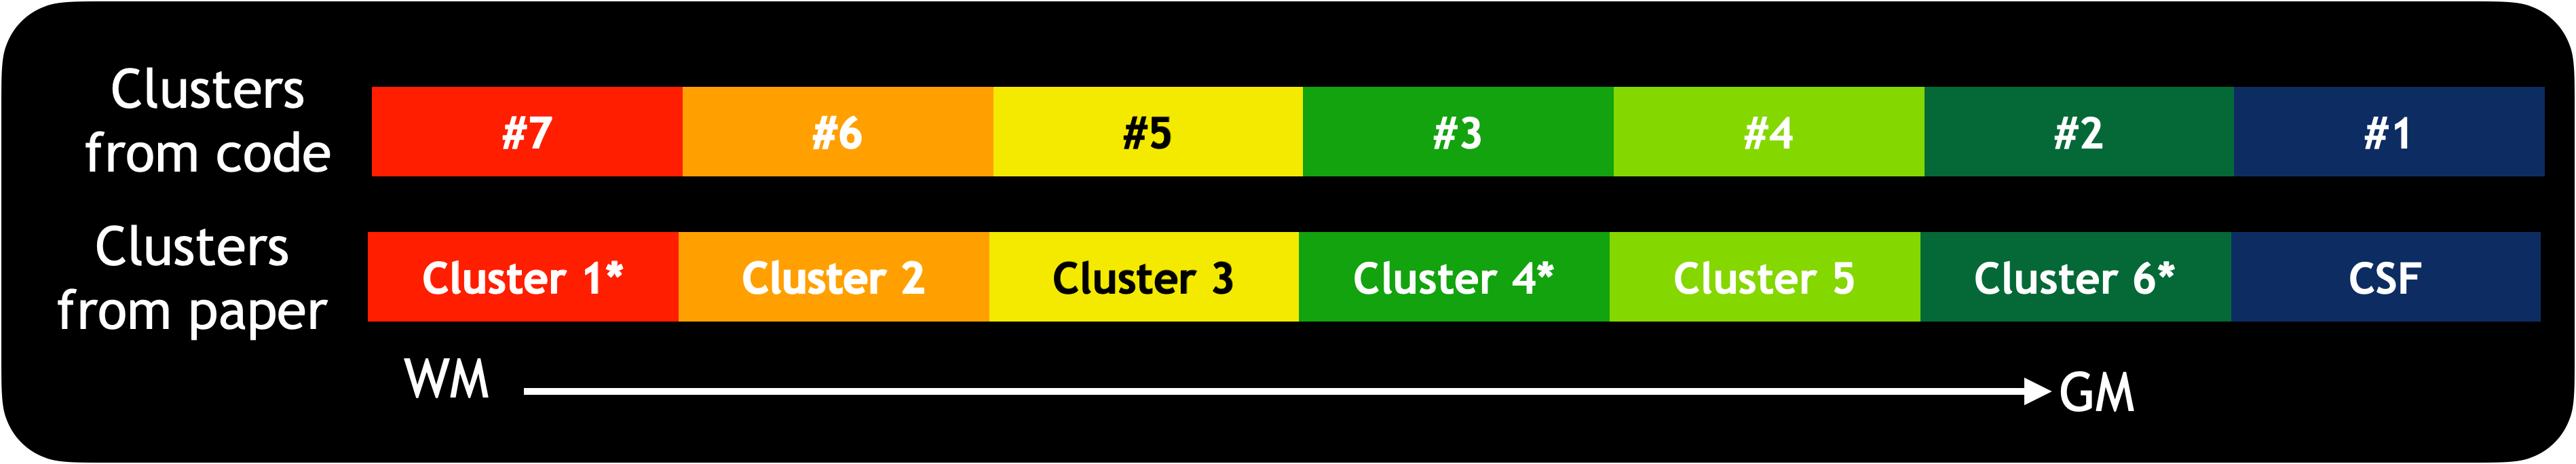
### We want to look at differences between the atlas and each subject based on the ordering presented in the paper. So for example, if the atlas has a red voxel but the same voxel in an MS subject is yellow, that will count as a 2-cluster difference.

In [4]:
subject_list = ["LOBSTR_P026"] 

for subject in subject_list:
    #Load in each subject's clustered brain and clustered atlas registered to the person. We will use this to pull out specific differences.
    folder_clustering = base_folder + subject + "/clustering_outputs/" ## Folder location of clustering outputs
    folder_mask = base_folder+ subject + "/ants/CALIPR/" ## Location where no-CSF mask lives
    clustered_subject = nib.load(folder_clustering + "recoloured_6cluster.nii.gz"). get_fdata() ## Clustered map
    clustered_atlas = nib.load(folder_clustering + "atlas_clustering_rebinarized.nii.gz").get_fdata() ## Atlas warped to the subject
    img_mask = nib.load(folder_mask+"mask_no_csf.nii.gz") ## No-CSF mask
    mask = img_mask.get_fdata() #No-CSF mask

    ##Reorder the clusters in atlas. This is only needed because cluster3 and cluster4 are swapped in the paper.
    data_nonzero = clustered_atlas[mask== 1]
    data_nonzero[data_nonzero==1] = -1
    data_nonzero[data_nonzero==2] = -2
    data_nonzero[data_nonzero==3] = -3
    data_nonzero[data_nonzero==4] = -4
    data_nonzero[data_nonzero==5] = -5
    data_nonzero[data_nonzero==6] = -6
    data_nonzero[data_nonzero==7] = -7

    ## Be careful of this, this is the re-classification. Only 3 and 4 are swapped around to be similar to paper.
    data_nonzero[data_nonzero==-1] = 1
    data_nonzero[data_nonzero==-2] = 2
    data_nonzero[data_nonzero==-3] = 4
    data_nonzero[data_nonzero==-4] = 3
    data_nonzero[data_nonzero==-5] = 5
    data_nonzero[data_nonzero==-6] = 6
    data_nonzero[data_nonzero==-7] = 7 
    clustered_atlas = mask.copy()

    ## Replacing cluster labels
    clustered_atlas[mask==1] = data_nonzero

    ### Reorder in subject as well.
    data_nonzero = clustered_subject[mask== 1]
    data_nonzero[data_nonzero==1] = -1
    data_nonzero[data_nonzero==2] = -2
    data_nonzero[data_nonzero==3] = -3
    data_nonzero[data_nonzero==4] = -4
    data_nonzero[data_nonzero==5] = -5
    data_nonzero[data_nonzero==6] = -6
    data_nonzero[data_nonzero==7] = -7
    ##Be careful of this, this is the re-classification. Only 3 and 4 are swapped around.
    data_nonzero[data_nonzero==-1] = 1
    data_nonzero[data_nonzero==-2] = 2
    data_nonzero[data_nonzero==-3] = 4
    data_nonzero[data_nonzero==-4] = 3
    data_nonzero[data_nonzero==-5] = 5
    data_nonzero[data_nonzero==-6] = 6
    data_nonzero[data_nonzero==-7] = 7 
    clustered_subject = mask.copy()
    # Replacing cluster labels
    clustered_subject[mask==1] = data_nonzero


    ## Now take the difference between cluster 7 (what atlas shows as red) and whatever the subject shows in those locations. The subject could show any other colour, or red!
    diff_red = np.zeros(mask.shape)
    diff_red[clustered_atlas==7] = clustered_atlas[clustered_atlas==7] - clustered_subject[clustered_atlas==7] ##This is every voxel that is not classified as 7 in the subject when the atlas says it should be
    new_header = img_mask.header.copy()
    ni_img = nib.Nifti1Image(diff_red, None, header=new_header)
    nib.save(ni_img, folder_clustering+"testing_red_diffs.nii.gz") ## Save as a NIFTI, this is a "difference map" of red voxels.

    ## Take the difference between cluster 6 (what atlas shows as orange) and all other clusters, to point out every voxel that the atlas thinks should be orange but is not.
    diff_orange = np.zeros(mask.shape)
    diff_orange[clustered_atlas==6] = clustered_atlas[clustered_atlas==6] - clustered_subject[clustered_atlas==6] ##This is every voxel that is not classified as 6 in the subject when the atlas says it should be
    new_header = img_mask.header.copy()
    ni_img = nib.Nifti1Image(diff_orange, None, header=new_header)
    nib.save(ni_img, folder_clustering+"testing_orange_diffs.nii.gz") 
    !fslmaths {folder_clustering}testing_orange_diffs.nii.gz -thr 0 {folder_clustering}testing_orange_diffs.nii.gz

    ## Finally take the difference between cluster 5 (what atlas shows as yellow) and all other clusters. 
    diff_yellow = np.zeros(mask.shape)
    diff_yellow[clustered_atlas==5] = clustered_atlas[clustered_atlas==5] - clustered_subject[clustered_atlas==5] ##This is every voxel that is not classified as 5 in the subject when the atlas says it should be
    new_header = img_mask.header.copy()
    ni_img = nib.Nifti1Image(diff_yellow, None, header=new_header)
    nib.save(ni_img, folder_clustering+"testing_yellow_diffs.nii.gz") ##This is just a combined thing of all differences from the red cluster
    !fslmaths {folder_clustering}testing_yellow_diffs.nii.gz -thr 0 {folder_clustering}testing_yellow_diffs.nii.gz

    
    ## Put together the masks and remove exta masks if needed. This is a difference map showing regions of white matter in the atlas that are classified differently in the subject.
    !fslmaths {folder_clustering}testing_red_diffs.nii.gz -add {folder_clustering}testing_orange_diffs.nii.gz -add {folder_clustering}testing_yellow_diffs.nii.gz {folder_clustering}testing_redorangeyellow_diffs.nii.gz
    # !rm {folder_clustering}testing_red_diffs.nii.gz
    # !rm {folder_clustering}testing_orange_diffs.nii.gz
    # !rm {folder_clustering}testing_yellow_diffs.nii.gz
    # !rm {folder_clustering}testing_darkgreen_diffs.nii.gz


## We want to quantify these difference maps. Each difference map for each subject will have values from 0..5. As we did with the calculating cluster sizes, we can calculate cluster sizes of these differences; this will show how much "1-cluster difference", "2-cluster difference" etc there is in the subject compared to the atlas.

### We can store all this in one big dataframe.

In [2]:
## To make life easier, I've already made a file with a column each for subject IDs, subject age, category (HC, RRMS, ProgMS), 
## clinical scores, and headers for each cluster so we can deal with one master sheet, Clustering_Subjects_withvalues.csv.

## First load in the Clustering_Subjects_withvalues.csv file since it has all the patient IDs and their data already filled in.
data = pd.read_csv(base_folder + 'Clustering_Subjects_withvalues.csv', sep=',', header=0, index_col=0 )
#print(data)

subject_list = ["LOBSTR_P023", "LOBSTR_P039", "LOBSTR_P034", "LOBSTR_P045", "LOBSTR_P098", "LOBSTR_P007", 
                "LOBSTR_P077", "LOBSTR_P026", "LOBSTR_P008", "LOBSTR_P066", "LOBSTR_P076", "LOBSTR_P012", 
                "LOBSTR_P052", "LOBSTR_P025", "LOBSTR_P003", "LOBSTR_P018", "LOBSTR_P020", "LOBSTR_P024", 
                "LOBSTR_P054", "LOBSTR_P002", "LOBSTR_P072", "LOBSTR_P085", "LOBSTR_P087", "LOBSTR_P027", "LOBSTR_P035"]


for subject in subject_list:
    #print(data['Age'][subject])

    #Load in each subject's clustered brain
    folder_clustering = base_folder + subject + "/clustering_outputs/" ## Folder location of clustering outputs
    folder_mask = base_folder + subject + "/ants/CALIPR/" ## Location of no-CSF mask
    clustered = nib.load(folder_clustering + "testing_redorangeyellow_diffs.nii.gz").get_fdata() ## The difference map
    mask = nib.load(folder_mask+"mask_no_csf.nii.gz").get_fdata()

    data_nonzero = clustered[mask==1] ## Wherever no-CSF mask is 1, fill in difference map data.
    #print(len(data_nonzero))
    #Get the voxels out for each cluster
    cluster1 = data_nonzero[data_nonzero==1]
    cluster2 = data_nonzero[data_nonzero==2]
    cluster3 = data_nonzero[data_nonzero==3]
    cluster4 = data_nonzero[data_nonzero==4]
    cluster5 = data_nonzero[data_nonzero==5]
    cluster6 = data_nonzero[data_nonzero==6]
    cluster7 = data_nonzero[data_nonzero==7]
    
    #For normalization, get total number of tissue voxels in the subject's brain
    total_len = len(data_nonzero)
    print(subject, len(cluster1)/total_len, len(cluster2)/total_len, len(cluster3)/total_len, len(cluster4)/total_len, len(cluster5)/total_len, len(cluster6)/total_len, len(cluster7)/total_len)
    #print(subject, len(cluster2)/total_len, len(cluster4)/total_len)

    data['Cluster1'][subject] = len(cluster1)/total_len
    data['Cluster2'][subject] = len(cluster2)/total_len
    data['Cluster3'][subject] = len(cluster3)/total_len
    data['Cluster4'][subject] = len(cluster4)/total_len
    data['Cluster5'][subject] = len(cluster5)/total_len
    data['Cluster6'][subject] = len(cluster6)/total_len
    data['Cluster7'][subject] = len(cluster7)/total_len
    data['Total'][subject] = (len(cluster1) + len(cluster2) + len(cluster3) + len(cluster4) + len(cluster5) + len(cluster6) + len(cluster7))/total_len
    
## Save this dataframe of everyone's differences to a single file
data.to_csv(base_folder + 'difference_Cluster_values_total_redorangeyellow.csv')

LOBSTR_P023 0.0698176345959646 0.05943943063218801 0.014729215397449483 0.007280669508225512 0.0006310430116506209 0.0 0.0
LOBSTR_P039 0.07275584663740463 0.028443448383631987 0.01034226293499912 0.009827968517269412 0.0011176013308357086 0.0 0.0


/var/folders/dz/kq0xzjn15wd04d7z52q7876m0000gn/T/ipykernel_13165/676870235.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster1'][subject] = len(cluster1)/total_len
/var/folders/dz/kq0xzjn15wd04d7z52q7876m0000gn/T/ipykernel_13165/676870235.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster2'][subject] = len(cluster2)/total_len
/var/folders/dz/kq0xzjn15wd04d7z52q7876m0000gn/T/ipykernel_13165/676870235.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

LOBSTR_P034 0.08026413025340294 0.040307602955103494 0.012269227351827653 0.008643612698536534 0.0007574132225494594 0.0 0.0
LOBSTR_P045 0.06849496159898337 0.038247497857133717 0.014296862673188372 0.009442257749499998 0.0009680211855914098 0.0 0.0
LOBSTR_P098 0.07553676681964512 0.047862005410992836 0.01345612386158134 0.010967760350511639 0.0010000346597129769 0.0 0.0
LOBSTR_P007 0.08103658374935209 0.042153723234552305 0.015185103587984652 0.010022844846105817 0.0016363455193842953 0.0 0.0
LOBSTR_P077 0.05461894984595558 0.038442732149183784 0.009688119622171622 0.008166322388962671 0.0006443552614404137 0.0 0.0
LOBSTR_P026 0.07837343355633686 0.03981219208429313 0.0128335409066361 0.011404040515369609 0.001224498793135753 0.0 0.0
LOBSTR_P008 0.07026821970724464 0.04276606289528805 0.01295208920125554 0.008797549290546535 0.000608802240229081 0.0 0.0
LOBSTR_P066 0.06485833221431449 0.03443576121558414 0.012685251224421039 0.00916978986836318 0.0009488207685609042 0.0 0.0
LOBSTR_P07

### After some testing, it looks like 1-cluster changes from white matter (red->orange, orange->yellow and yellow->dark green) are most strongly related to SDMT scores. So let us make a composite "score" with these differences and check the relationship with SDMT.

486.00664809662715
MS:  SignificanceResult(statistic=-0.5991733499052623, pvalue=0.0019749319548148982)
ProgMS:  SignificanceResult(statistic=-0.7643190347182212, pvalue=0.0014567591662637464)
RRMS:  SignificanceResult(statistic=-0.3039527718400323, pvalue=0.3932011151432977)


/Users/sharada/Documents/Venvs/mri_venv_basic/lib/python3.8/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


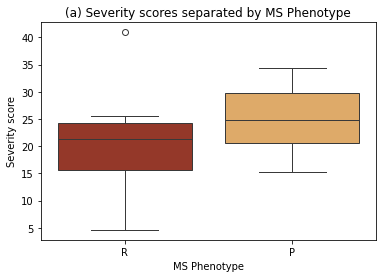

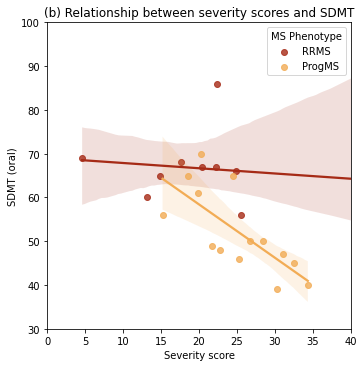

In [3]:
## Load in the file that holds cluster differences
df = pd.read_csv(base_folder + 'difference_Cluster_values_total_redorangeyellow.csv', sep=',', header=0, index_col=False )

## Make a new dataframe and file to hold subject ID, subject categorization, clinical scores, 
## and calculate and hold the severity score (reflecting 1-cluster changes)
severity_df = pd.DataFrame()
severity_df['SubjectID'] = df[df['CorMS']=='M']['SubjectID']
severity_df['OverallType'] = df[df['CorMS']=='M']['OverallType']
severity_df['CorMS'] = df[df['CorMS']=='M']['CorMS']
severity_df['SDMT_O'] = df[df['CorMS']=='M']['SDMT_O']
severity_df['SDMT_W'] = df[df['CorMS']=='M']['SDMT_W']
severity_df['9HPT_D'] = df[df['CorMS']=='M']['9HPT_D']
severity_df['EDSS'] = df[df['CorMS']=='M']['EDSS']
severity_df['Age'] = df[df['CorMS']=='M']['Age']
### This is the calculation of the actual severity score-- just scale the 1-cluster differences.
severity_df['Severity'] = (((df['Cluster1']*1000))-50)
## Save this dataframe so we can look at it again later
#severity_df.to_csv(base_folder + 'severity_scores.csv')


## If already have a file, read it back in and plot out.
data = pd.read_csv(base_folder + 'severity_scores.csv', sep=',', header=0, index_col=False )

## Make boxplot of severity scores
my_pal = ["#F2AC55", "#A62B17"]
g = sns.boxplot(data=data, x='OverallType', y='Severity', hue='OverallType', order=['R','P'], palette=my_pal)
g.set_xlabel('MS Phenotype')
g.set_ylabel('Severity score')
g.set_title('(a) Severity scores separated by MS Phenotype')
#plt.savefig('/Users/sharada/Documents/Projects/MDDE/V3/Plots/SeverityScores.png', dpi=300, bbox_inches="tight")

## #Make regression plot of SDMT scores and severity metric
print(np.var(data[data['OverallType']=='R']['Severity_scaled']))
print('MS: ', spearmanr(data[data['CorMS']=='M']['Severity'], data[data['CorMS']=='M']['SDMT_O']))
print('ProgMS: ', spearmanr(data[data['OverallType']=='P']['Severity'], data[data['OverallType']=='P']['SDMT_O']))
print('RRMS: ', spearmanr(data[data['OverallType']=='R']['Severity'], data[data['OverallType']=='R']['SDMT_O']))

my_pal = ["#A62B17", "#F2AC55"]
g = sns.lmplot(data=data, x='Severity', y='SDMT_O', hue='OverallType', hue_order=['R','P'], palette=my_pal, legend_out=False)
g.set(xlabel='Severity score', ylabel='SDMT (oral)', title='(b) Relationship between severity scores and SDMT', xlim=[0,40], ylim=[30,100])
g.despine(top=False, right=False)
leg = g.axes.flat[0].get_legend()
leg.set_title('MS Phenotype')
labels=['RRMS', 'ProgMS']
for t, l in zip(leg.texts, labels):
    t.set_text(l)

